The goal of this exercise is to present a practical example of optimal control. We will consider a buck converter with the goal of output voltage control. 



In [5]:
pkg load control
clear all

State space averaged model of the Buck converter is presented below. The basic operation of the converter is to step down the input DC voltage by a factor called as the duty cycle. Due to the switching action of the converter, the output voltage needs to be filtered out and therefore an LC output filter is used at the output. We typically define state variables accross the energy storing components, in this case the inductor and the capacitor. The two states are the inductor current $i_L$ and the capacitor voltage $v_c$. The control input $u$ is the duty cycle ratio which lies between 0 and 1.

$x = \begin{bmatrix} i_L \\ v_c \end{bmatrix}$

$\dot{x} = \begin{bmatrix} \frac{-r}{L} \frac{-1}{L} \\ \frac{1}{C} \frac{-1}{R_L C} \end{bmatrix}   x + \begin{bmatrix} \frac{V_{dc}}{L} \\ 0 \end{bmatrix}u$

Let us define the parameters of the buck converter. Inductor $L = 1 mH$ ; internal coil resistance of the inductor, $r = 0.1 \Omega$ ; filter capacitance $C_o = 1 mF$; the load resistor $R_L = 10 \Omega$. Let us consider the input DC voltage $V_{dc} = 500 V$.

In [6]:
L = 1e-3;
r = 0.1;
C_o = 1e-3;
R_L = 10;
V_dc = 500;

In [7]:
A = [-r/L -1/L; 1/C_o -1/(R_L*C_o)]
B = [V_dc/L; 0]
C = [0 1]
D = [0]

A =

   -100  -1000
   1000   -100

B =

   500000
        0

C =

   0   1

D = 0


Pole of the open loop system:

In [8]:
OL_Poles = eig(A)

OL_Poles =

   -100 + 1000i
   -100 - 1000i



Let us check if the system is controllable by calculating the controllability matrix $W_c$

In [9]:
Wc = [B A*B]
rank(Wc)
det(Wc)

Wc =

      500000   -50000000
           0   500000000

ans =  2
ans =    2.5000e+14


The controllability matrix has full rank or the determinant is non-zero and hence the system is controllable.
Let us define the Q and R matrices.

In [10]:
Ql = [10 0;0 100]
Rl = 1

Ql =

    10     0
     0   100

Rl =  1


In [11]:
% Control Design by Discritizing the system
sys_cont = ss(A,B,C,D)
Ts = 1e-4; % Simulation time step
sys_disc = c2d(sys_cont,Ts)
Ql = [1 0;0 1]
Rl = 1e3;
K = dlqr(sys_disc.A,sys_disc.B,Ql,Rl)

%Position closed loop eigen values
CL_poles = eig(A-B*K)
CL_poles = eig(sys_disc.A-sys_disc.B*K)


sys_cont.a =
          x1     x2
   x1   -100  -1000
   x2   1000   -100

sys_cont.b =
          u1
   x1  5e+05
   x2      0

sys_cont.c =
       x1  x2
   y1   0   1

sys_cont.d =
       u1
   y1   0

Continuous-time model.

sys_disc.a =
             x1        x2
   x1    0.9851  -0.09884
   x2   0.09884    0.9851

sys_disc.b =
          u1
   x1  49.67
   x2  2.481

sys_disc.c =
       x1  x2
   y1   0   1

sys_disc.d =
       u1
   y1   0

Sampling time: 0.0001 s
Discrete-time model.
Ql =

   1   0
   0   1

K =

   0.016142   0.011252

CL_poles =

  -7243.3
  -1027.6

CL_poles =

   0.23706
   0.90349



In [12]:
x = [10; 100];  % Inititialize states

Simulation setup

In [13]:
T_sim = 0.2; % Simulation time
npoints = floor(T_sim/Ts) % total number of simulation time stamps

npoints =  2000


In [14]:
y_ref = 200;
setpoint = ([sys_disc.A - eye(size(A,1)) sys_disc.B; C 0])\[zeros(size(sys_disc.A,1),1);y_ref]
x_ref = setpoint(1:2,1);
u_ref = setpoint(3,1)

setpoint =

    20.00000
   200.00000
     0.40400

u_ref =  0.40400


Let us now simulate the system. At half the simulation time, a reference step in the output voltage is made. At each simulation time step, the controller action is calculated along with the set-point trajectory calculation.   

In [15]:
for i=1:npoints
    t(i,1) = (i-1)*Ts; % time stamp
    
    if t(i,1) > T_sim/2
        y_ref = 350;
    end
    
    
    setpoint = ([sys_disc.A - eye(size(A,1)) sys_disc.B; C 0])\[zeros(size(sys_disc.A,1),1);y_ref];
    x_ref = setpoint(1:2,1);
    u_ref = setpoint(3,1);
    
    u(i,1) = -K*(x(:,i)-x_ref) + u_ref;
    if(u(i,1) < 0)
        u(i,1) = 0;
    end
    if(u(i,1) > 1)
        u(i,1) = 1;
    end
    x(:,i+1)= sys_disc.A*x(:,i) + sys_disc.B*u(i,1);
end
t(i+1,1) = npoints*Ts;
u(i+1) = -K*x(:,i+1);

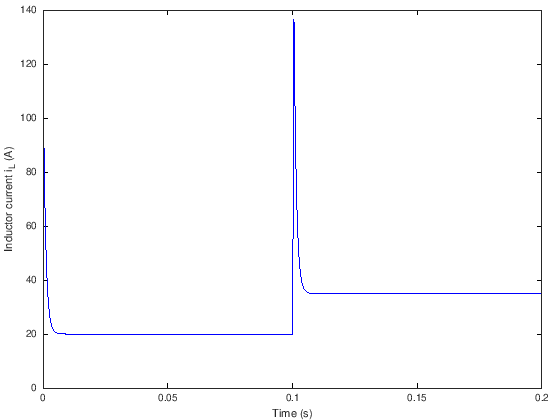

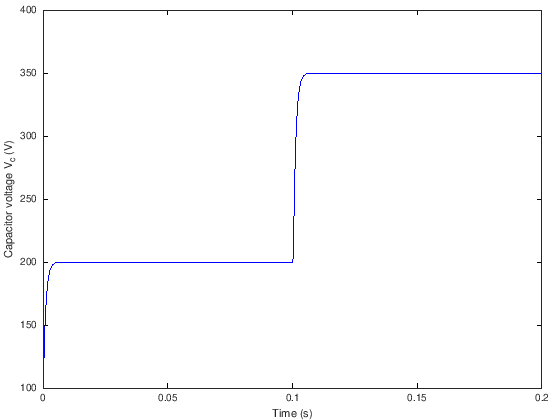

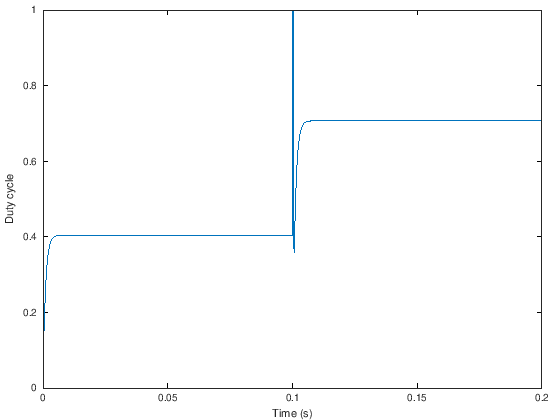

In [16]:
figure
plot(t,x(1,:),'b')
xlabel('Time (s)')
ylabel('Inductor current i_L (A)')
figure
plot(t,x(2,:),'b')
xlabel('Time (s)')
ylabel('Capacitor voltage V_c (V)')
figure
plot(t,u)
xlabel('Time (s)')
ylabel('Duty cycle')
ylim([0 1])

The overshoot in the inductor is very drastic, let us attempt to minimize the overshoot in the current by adding more weight ($Q$) to the inductor current state variable. 

Ql =

   100000        0
        0      100

Rl =  1
K =

   0.0198386  -0.0018927

npoints =  2000
setpoint =

    20.00000
   200.00000
     0.40400

u_ref =  0.40400


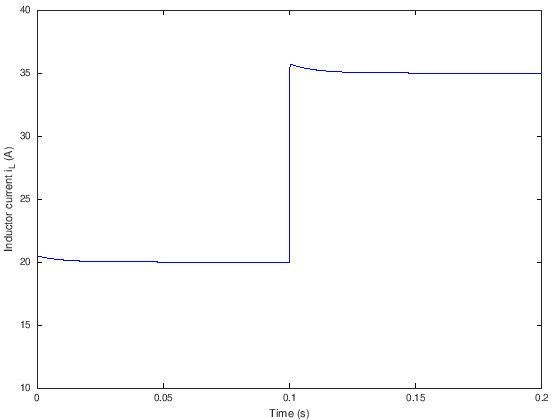

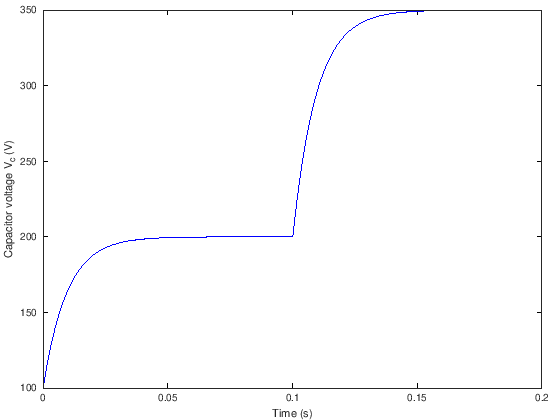

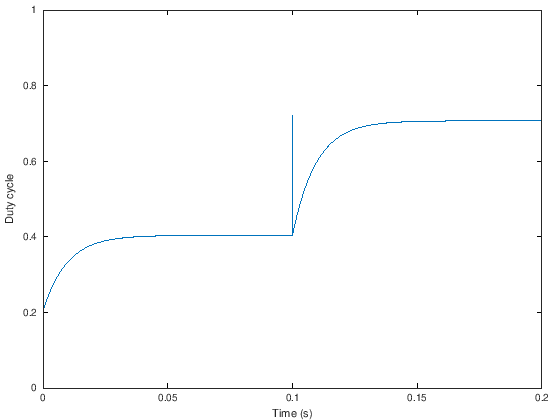

In [17]:
Ql = [1e5 0;0 100]
Rl = 1
K = dlqr(sys_disc.A,sys_disc.B,Ql,Rl)
x = [10; 100]; % Inititialize states
T_sim = 0.2; % Simulation time
npoints = floor(T_sim/Ts) % total number of simulation time stamps
y_ref = 200;
setpoint = ([sys_disc.A - eye(size(A,1)) sys_disc.B; C 0])\[zeros(size(sys_disc.A,1),1);y_ref]
x_ref = setpoint(1:2,1);
u_ref = setpoint(3,1)
for i=1:npoints
    t(i,1) = (i-1)*Ts; % time stamp
    
    if t(i,1) > T_sim/2
        y_ref = 350;
    end
    
    
    setpoint = ([sys_disc.A - eye(size(A,1)) sys_disc.B; C 0])\[zeros(size(sys_disc.A,1),1);y_ref];
    x_ref = setpoint(1:2,1);
    u_ref = setpoint(3,1);
    
    u(i,1) = -K*(x(:,i)-x_ref) + u_ref;
    if(u(i,1) < 0)
        u(i,1) = 0;
    end
    if(u(i,1) > 1)
        u(i,1) = 1;
    end
    x(:,i+1)= sys_disc.A*x(:,i) + sys_disc.B*u(i,1);
end
t(i+1,1) = npoints*Ts;
u(i+1) = -K*x(:,i+1);
figure
plot(t,x(1,:),'b')
xlabel('Time (s)')
ylabel('Inductor current i_L (A)')
figure
plot(t,x(2,:),'b')
xlabel('Time (s)')
ylabel('Capacitor voltage V_c (V)')
figure
plot(t,u)
xlabel('Time (s)')
ylabel('Duty cycle')
ylim([0 1])

The overshoot in the current is significantly reduced due to the significantly higher weighting on Q(1,1), which is the weighting on the inductor current state variable.

LQR formulation is formally defined as a regulator problem where the goal is drive the states to a defined equilibrium point. However, in this application we would like to perform a reference tracking wherein the voltage reference command needs to be tracked. Thus, we define a set-point trajectory generator which determines the desired nominal state $x_{nom}$ and desired nominal control input $u_{nom}$. First let us define the set-point trajectory generator for a continuous time system. Consider the state space equation in $\textbf{steady state}$ of the form:

 \begin{equation}  \dot{x} = 0 = Ax_{nom}+ Bu_{nom} \end{equation}

 \begin{equation}  y = Cx_{nom} \end{equation}

Putting the above equations in a matrix form:
\begin{equation} \begin{bmatrix} A & B \\ C & 0 \end{bmatrix} \begin{bmatrix} x_{nom} \\ u_{nom} \end{bmatrix} = 
\begin{bmatrix} 0 \\ y \end{bmatrix} 
\end{equation}

From the above equation the steady state set-point can be obtained as

\begin{equation} \begin{bmatrix} x_{nom} \\ u_{nom} \end{bmatrix}  = \begin{bmatrix} A & B \\ C & 0 \end{bmatrix}^{-1} 
\begin{bmatrix} 0 \\ y \end{bmatrix} 
\end{equation}

For a discrete time system, we have $x(k+1) = x(k)$ in steady state.



\begin{equation}  x(k+1) = x(k) = Ax(k)+ B u(k) \end{equation}

From the above equation the steady state set-point can be obtained as

\begin{equation} \begin{bmatrix} x_{nom} \\ u_{nom} \end{bmatrix}  = \begin{bmatrix} A-I & B \\ C & 0 \end{bmatrix}^{-1} 
\begin{bmatrix} 0 \\ y \end{bmatrix} 
\end{equation}